In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import OrderedDict
import pickle

import numpy as np

import IPython

#hey before executing this cell just download the weights of the model and make folder in you drive named styleGan_weight and upload the weight in this folder
#download weights from : https://drive.google.com/file/d/1-x1Sdsx4MIm16bFiwII-q-Jmn3t1-LLg/view?usp=sharing
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
class MyLinear(nn.Module):
    """Linear layer with equalized learning rate and custom learning rate multiplier."""
    def __init__(self, input_size, output_size, gain=2**(0.5), use_wscale=False, lrmul=1, bias=True):
        super().__init__()
        he_std = gain * input_size**(-0.5) # He init
        # Equalized learning rate and custom learning rate multiplier.
        if use_wscale:
            init_std = 1.0 / lrmul
            self.w_mul = he_std * lrmul
        else:
            init_std = he_std / lrmul
            self.w_mul = lrmul
        self.weight = torch.nn.Parameter(torch.randn(output_size, input_size) * init_std)
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(output_size))
            self.b_mul = lrmul
        else:
            self.bias = None

    def forward(self, x):
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul
        return F.linear(x, self.weight * self.w_mul, bias)

In [3]:
gain = 2**(0.5)
gain

1.4142135623730951

In [4]:
he_std = gain*(512**(-0.5)) # input_size = 512
he_std

0.06250000000000001

In [5]:
lrmul = 1
init_std = 1.0/lrmul
print(init_std)
print('w_mul when use wscale :',he_std*init_std)

1.0
w_mul when use wscale : 0.06250000000000001


In [6]:
torch.randn(512,512)*init_std

tensor([[ 0.5661, -0.5889, -0.0600,  ...,  0.4958,  0.0451, -0.5168],
        [-0.4466, -0.4337,  0.9947,  ..., -0.6876,  1.6475,  0.0204],
        [-0.1772, -0.3687,  0.7212,  ..., -0.8368,  0.1685, -0.1111],
        ...,
        [-1.0523, -1.4063,  0.5176,  ..., -0.2775, -1.4797,  1.3600],
        [-1.1898,  0.0568,  0.0935,  ..., -1.6557,  1.3725,  0.8402],
        [ 1.2647,  0.0196, -2.2552,  ...,  0.2720, -1.2660, -0.0195]])

In [7]:
weight = torch.nn.Parameter(torch.randn(512,512)*init_std) # Parameter(..) ==> requires_grad=True
weight

Parameter containing:
tensor([[-1.0114,  2.2942,  0.8886,  ...,  0.1771,  1.0482, -1.1340],
        [-0.4979,  1.0117,  0.2263,  ...,  0.0643,  0.4785, -0.6858],
        [ 0.4968, -0.2478,  0.1861,  ...,  0.1559,  1.1541,  0.8625],
        ...,
        [ 1.8993, -0.8794,  0.5415,  ..., -0.0202,  0.3818,  0.5862],
        [ 0.7482, -0.4183, -1.2055,  ..., -0.0662,  1.3441,  1.3056],
        [ 0.0300,  0.2543, -0.0802,  ..., -1.4247,  1.8337,  0.7305]],
       requires_grad=True)

In [8]:
bias = torch.nn.Parameter(torch.zeros(512,512))
bias

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)

In [9]:
w_mul = lrmul
b_mul = lrmul

F.linear(torch.randn(512,512), weight*w_mul, bias*b_mul)

tensor([[-46.8300,  -1.7916,  30.9231,  ...,  10.0069, -13.0616,   9.4551],
        [-19.6756,  -2.0594,  -2.8033,  ...,   3.1093,   7.5216,   9.5496],
        [ -7.5105,  61.3224, -11.7510,  ...,  -1.8310, -31.3355,  -3.4917],
        ...,
        [ 39.3980,  10.5246, -12.8977,  ...,  21.2041, -14.9203,  61.1305],
        [-32.7028,  36.4659,  -4.8374,  ...,  14.2824,  11.7000,   9.6300],
        [ -4.5345,  50.2508,  19.0532,  ...,  -0.8008,  -9.0197,  18.5577]],
       grad_fn=<AddmmBackward0>)

In [10]:
class MyConv2d(nn.Module):
    """Conv layer with equalized learning rate and custom learning rate multiplier."""
    def __init__(self, input_channels, output_channels, kernel_size, gain=2**(0.5), use_wscale=False, lrmul=1, bias=True,
                intermediate=None, upscale=False):
        super().__init__()
        if upscale:
            self.upscale = Upscale2d()
        else:
            self.upscale = None
        he_std = gain * (input_channels * kernel_size ** 2) ** (-0.5) # He init
        self.kernel_size = kernel_size
        if use_wscale:
            init_std = 1.0 / lrmul
            self.w_mul = he_std * lrmul
        else:
            init_std = he_std / lrmul
            self.w_mul = lrmul
        self.weight = torch.nn.Parameter(torch.randn(output_channels, input_channels, kernel_size, kernel_size) * init_std)
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(output_channels))
            self.b_mul = lrmul
        else:
            self.bias = None
        self.intermediate = intermediate

    def forward(self, x):
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul
        
        have_convolution = False
        if self.upscale is not None and min(x.shape[2:]) * 2 >= 128:
            # this is the fused upscale + conv from StyleGAN, sadly this seems incompatible with the non-fused way
            # this really needs to be cleaned up and go into the conv...
            w = self.weight * self.w_mul
            w = w.permute(1, 0, 2, 3)
            # probably applying a conv on w would be more efficient. also this quadruples the weight (average)?!
            w = F.pad(w, (1,1,1,1))
            w = w[:, :, 1:, 1:]+ w[:, :, :-1, 1:] + w[:, :, 1:, :-1] + w[:, :, :-1, :-1]
            x = F.conv_transpose2d(x, w, stride=2, padding=(w.size(-1)-1)//2)
            have_convolution = True
        elif self.upscale is not None:
            x = self.upscale(x)
    
        if not have_convolution and self.intermediate is None:
            return F.conv2d(x, self.weight * self.w_mul, bias, padding=self.kernel_size//2)
        elif not have_convolution:
            x = F.conv2d(x, self.weight * self.w_mul, None, padding=self.kernel_size//2)
        
        if self.intermediate is not None:
            x = self.intermediate(x)
        if bias is not None:
            x = x + bias.view(1, -1, 1, 1)
        return x

In [11]:
class NoiseLayer(nn.Module):
    """adds noise. noise is per pixel (constant over channels) with per-channel weight"""
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(channels))
        self.noise = None
    
    def forward(self, x, noise=None):
        if noise is None and self.noise is None:
            noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=x.device, dtype=x.dtype)
        elif noise is None:
            # here is a little trick: if you get all the noiselayers and set each
            # modules .noise attribute, you can have pre-defined noise.
            # Very useful for analysis
            noise = self.noise
        x = x + self.weight.view(1, -1, 1, 1) * noise
        return x

In [12]:
class StyleMod(nn.Module):
    def __init__(self, latent_size, channels, use_wscale):
        super(StyleMod, self).__init__()
        self.lin = MyLinear(latent_size,
                            channels * 2,
                            gain=1.0, use_wscale=use_wscale)
        
    def forward(self, x, latent):
        style = self.lin(latent) # style => [batch_size, n_channels*2]
        shape = [-1, 2, x.size(1)] + (x.dim() - 2) * [1]
        style = style.view(shape)  # [batch_size, 2, n_channels, ...]
        x = x * (style[:, 0] + 1.) + style[:, 1]
        return x

In [16]:
lin = MyLinear(512, 3*2, 1.0, use_wscale=True)

In [14]:
latent1 = torch.from_numpy(np.random.randn(3,512).astype(np.float64))
latent2 = torch.from_numpy(np.random.randn(3,512).astype(np.float64))
latent = torch.cat([latent1,latent2], axis=0)

In [15]:
latent.size()

torch.Size([6, 512])

In [17]:
class PixelNormLayer(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon
    def forward(self, x):
        return x * torch.rsqrt(torch.mean(x**2, dim=1, keepdim=True) + self.epsilon)

In [18]:
class BlurLayer(nn.Module):
    def __init__(self, kernel=[1, 2, 1], normalize=True, flip=False, stride=1):
        super(BlurLayer, self).__init__()
        kernel=[1, 2, 1]
        kernel = torch.tensor(kernel, dtype=torch.float32)
        kernel = kernel[:, None] * kernel[None, :]
        kernel = kernel[None, None]
        if normalize:
            kernel = kernel / kernel.sum()
        if flip:
            kernel = kernel[:, :, ::-1, ::-1]
        self.register_buffer('kernel', kernel)
        self.stride = stride
    
    def forward(self, x):
        # expand kernel channels
        kernel = self.kernel.expand(x.size(1), -1, -1, -1)
        x = F.conv2d(
            x,
            kernel,
            stride=self.stride,
            padding=int((self.kernel.size(2)-1)/2),
            groups=x.size(1)
        )
        return x

In [19]:
def upscale2d(x, factor=2, gain=1):
    assert x.dim() == 4
    if gain != 1:
        x = x * gain
    if factor != 1:
        shape = x.shape
        x = x.view(shape[0], shape[1], shape[2], 1, shape[3], 1).expand(-1, -1, -1, factor, -1, factor)
        x = x.contiguous().view(shape[0], shape[1], factor * shape[2], factor * shape[3])
    return x

class Upscale2d(nn.Module):
    def __init__(self, factor=2, gain=1):
        super().__init__()
        assert isinstance(factor, int) and factor >= 1
        self.gain = gain
        self.factor = factor
    def forward(self, x):
        return upscale2d(x, factor=self.factor, gain=self.gain)

In [20]:
class G_mapping(nn.Sequential):
    def __init__(self, nonlinearity='lrelu', use_wscale=True):
        act, gain = {'relu': (torch.relu, np.sqrt(2)),
                     'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
        layers = [
            ('pixel_norm', PixelNormLayer()),
            ('dense0', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense0_act', act),
            ('dense1', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense1_act', act),
            ('dense2', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense2_act', act),
            ('dense3', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense3_act', act),
            ('dense4', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense4_act', act),
            ('dense5', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense5_act', act),
            ('dense6', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense6_act', act),
            ('dense7', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense7_act', act)
        ]
        super().__init__(OrderedDict(layers))
        
    def forward(self, x):
        x = super().forward(x)
        # Broadcast
        x = x.unsqueeze(1).expand(-1, 18, -1)
        return x

In [21]:
class Truncation(nn.Module):
    def __init__(self, avg_latent, max_layer=8, threshold=0.7):
        super().__init__()
        self.max_layer = max_layer
        self.threshold = threshold
        self.register_buffer('avg_latent', avg_latent)
    def forward(self, x):
        assert x.dim() == 3
        interp = torch.lerp(self.avg_latent, x, self.threshold)
        do_trunc = (torch.arange(x.size(1)) < self.max_layer).view(1, -1, 1)
        return torch.where(do_trunc, interp, x)

In [22]:
class LayerEpilogue(nn.Module):
    """Things to do at the end of each layer."""
    def __init__(self, channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        layers = []
        if use_noise:
            layers.append(('noise', NoiseLayer(channels)))
        layers.append(('activation', activation_layer))
        if use_pixel_norm:
            layers.append(('pixel_norm', PixelNormLayer()))
        if use_instance_norm:
            layers.append(('instance_norm', nn.InstanceNorm2d(channels)))
        self.top_epi = nn.Sequential(OrderedDict(layers))
        if use_styles:
            self.style_mod = StyleMod(dlatent_size, channels, use_wscale=use_wscale)
        else:
            self.style_mod = None
    def forward(self, x, dlatents_in_slice=None):
        x = self.top_epi(x)
        if self.style_mod is not None:
            x = self.style_mod(x, dlatents_in_slice)
        else:
            assert dlatents_in_slice is None
        return x

In [23]:
class InputBlock(nn.Module):
    def __init__(self, nf, dlatent_size, const_input_layer, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        self.const_input_layer = const_input_layer
        self.nf = nf
        if self.const_input_layer:
            # called 'const' in tf
            self.const = nn.Parameter(torch.ones(1, nf, 4, 4))
            self.bias = nn.Parameter(torch.ones(nf))
        else:
            self.dense = MyLinear(dlatent_size, nf*16, gain=gain/4, use_wscale=use_wscale) # tweak gain to match the official implementation of Progressing GAN
        self.epi1 = LayerEpilogue(nf, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        self.conv = MyConv2d(nf, nf, 3, gain=gain, use_wscale=use_wscale)
        self.epi2 = LayerEpilogue(nf, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        
    def forward(self, dlatents_in_range):
        batch_size = dlatents_in_range.size(0)
        if self.const_input_layer:
            x = self.const.expand(batch_size, -1, -1, -1)
            x = x + self.bias.view(1, -1, 1, 1)
        else:
            x = self.dense(dlatents_in_range[:, 0]).view(batch_size, self.nf, 4, 4)
        x = self.epi1(x, dlatents_in_range[:, 0])
        x = self.conv(x)
        x = self.epi2(x, dlatents_in_range[:, 1])
        return x

In [24]:
class GSynthesisBlock(nn.Module):
    def __init__(self, in_channels, out_channels, blur_filter, dlatent_size, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        # 2**res x 2**res # res = 3..resolution_log2
        super().__init__()
        if blur_filter:
            blur = BlurLayer(blur_filter)
        else:
            blur = None
        self.conv0_up = MyConv2d(in_channels, out_channels, kernel_size=3, gain=gain, use_wscale=use_wscale,
                                 intermediate=blur, upscale=True)
        self.epi1 = LayerEpilogue(out_channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        self.conv1 = MyConv2d(out_channels, out_channels, kernel_size=3, gain=gain, use_wscale=use_wscale)
        self.epi2 = LayerEpilogue(out_channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
            
    def forward(self, x, dlatents_in_range):
        x = self.conv0_up(x)
        x = self.epi1(x, dlatents_in_range[:, 0])
        x = self.conv1(x)
        x = self.epi2(x, dlatents_in_range[:, 1])
        return x

In [25]:
class G_synthesis(nn.Module):
    def __init__(self,
        dlatent_size        = 512,          # Disentangled latent (W) dimensionality.
        num_channels        = 3,            # Number of output color channels.
        resolution          = 1024,         # Output resolution.
        fmap_base           = 8192,         # Overall multiplier for the number of feature maps.
        fmap_decay          = 1.0,          # log2 feature map reduction when doubling the resolution.
        fmap_max            = 512,          # Maximum number of feature maps in any layer.
        use_styles          = True,         # Enable style inputs?
        const_input_layer   = True,         # First layer is a learned constant?
        use_noise           = True,         # Enable noise inputs?
        randomize_noise     = True,         # True = randomize noise inputs every time (non-deterministic), False = read noise inputs from variables.
        nonlinearity        = 'lrelu',      # Activation function: 'relu', 'lrelu'
        use_wscale          = True,         # Enable equalized learning rate?
        use_pixel_norm      = False,        # Enable pixelwise feature vector normalization?
        use_instance_norm   = True,         # Enable instance normalization?
        dtype               = torch.float32,  # Data type to use for activations and outputs.
        blur_filter         = [1,2,1],      # Low-pass filter to apply when resampling activations. None = no filtering.
        ):
        
        super().__init__()
        def nf(stage):
            return min(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_max)
        self.dlatent_size = dlatent_size
        resolution_log2 = int(np.log2(resolution))
        assert resolution == 2**resolution_log2 and resolution >= 4

        act, gain = {'relu': (torch.relu, np.sqrt(2)),
                     'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
        num_layers = resolution_log2 * 2 - 2
        num_styles = num_layers if use_styles else 1
        torgbs = []
        blocks = []
        for res in range(2, resolution_log2 + 1):
            channels = nf(res-1)
            name = '{s}x{s}'.format(s=2**res)
            if res == 2:
                blocks.append((name,
                               InputBlock(channels, dlatent_size, const_input_layer, gain, use_wscale,
                                      use_noise, use_pixel_norm, use_instance_norm, use_styles, act)))
                
            else:
                blocks.append((name,
                               GSynthesisBlock(last_channels, channels, blur_filter, dlatent_size, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, act)))
            last_channels = channels
        self.torgb = MyConv2d(channels, num_channels, 1, gain=1, use_wscale=use_wscale)
        self.blocks = nn.ModuleDict(OrderedDict(blocks))
        
    def forward(self, dlatents_in):
        # Input: Disentangled latents (W) [minibatch, num_layers, dlatent_size].
        # lod_in = tf.cast(tf.get_variable('lod', initializer=np.float32(0), trainable=False), dtype)
        batch_size = dlatents_in.size(0)       
        for i, m in enumerate(self.blocks.values()):
            if i == 0:
                x = m(dlatents_in[:, 2*i:2*i+2])
            else:
                x = m(x, dlatents_in[:, 2*i:2*i+2])
        rgb = self.torgb(x)
        return rgb

In [26]:
g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    ('g_synthesis', G_synthesis())    
]))

In [27]:
import os
os.listdir('/content/drive/MyDrive/weight_styleGan')

['karras2019stylegan-ffhq-1024x1024.for_g_all.pt']

In [28]:
g_all.load_state_dict(torch.load('/content/drive/MyDrive/weight_styleGan/karras2019stylegan-ffhq-1024x1024.for_g_all.pt'))

<All keys matched successfully>

In [29]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
g_all.eval()
g_all.to(device)

Sequential(
  (g_mapping): G_mapping(
    (pixel_norm): PixelNormLayer()
    (dense0): MyLinear()
    (dense0_act): LeakyReLU(negative_slope=0.2)
    (dense1): MyLinear()
    (dense1_act): LeakyReLU(negative_slope=0.2)
    (dense2): MyLinear()
    (dense2_act): LeakyReLU(negative_slope=0.2)
    (dense3): MyLinear()
    (dense3_act): LeakyReLU(negative_slope=0.2)
    (dense4): MyLinear()
    (dense4_act): LeakyReLU(negative_slope=0.2)
    (dense5): MyLinear()
    (dense5_act): LeakyReLU(negative_slope=0.2)
    (dense6): MyLinear()
    (dense6_act): LeakyReLU(negative_slope=0.2)
    (dense7): MyLinear()
    (dense7_act): LeakyReLU(negative_slope=0.2)
  )
  (g_synthesis): G_synthesis(
    (torgb): MyConv2d()
    (blocks): ModuleDict(
      (4x4): InputBlock(
        (epi1): LayerEpilogue(
          (top_epi): Sequential(
            (noise): NoiseLayer()
            (activation): LeakyReLU(negative_slope=0.2)
            (instance_norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine

In [30]:
nb_rows = 3
nb_cols = 3
nb_samples = nb_rows * nb_cols

In [31]:
latents = torch.randn(nb_samples, 512, device=device)

In [32]:
latents

tensor([[-1.1176, -0.2396,  0.2568,  ..., -0.1551, -0.2897, -0.7945],
        [-0.9296,  0.5925, -0.0689,  ...,  0.6494, -0.4411, -0.2078],
        [-0.0395, -0.7396,  0.2331,  ..., -0.2532, -0.6657,  1.0553],
        ...,
        [-1.1747, -1.0504,  1.1184,  ...,  0.5508, -1.2918,  0.0380],
        [-0.5013, -0.2564,  1.1901,  ..., -1.1430, -0.1209,  0.3162],
        [-1.9048,  0.4973, -1.6001,  ...,  0.4861, -0.5346,  0.4455]])

In [33]:
latents.shape

torch.Size([9, 512])

In [34]:
import torchvision
import matplotlib.pyplot as plt

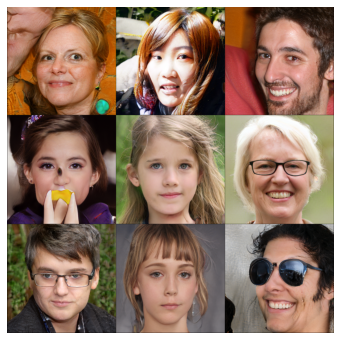

In [35]:
with torch.no_grad():
    imgs = g_all(latents)
    imgs = (imgs.clamp(-1, 1)+1)/2.0  # normalization to 0~1 range
imgs = imgs.cpu()

imgs = torchvision.utils.make_grid(imgs, nrow=nb_cols)

plt.figure(figsize=(15,6))
plt.imshow(imgs.permute(1,2,0).detach().numpy())
plt.axis('off')
plt.show()

In [36]:
latent1 = torch.randn(1, 512, device=device)
img1 = g_all(latent1)
img1 = img1.clamp(-1,1)+1/2.0
img1 = img1.cpu()

img1.shape

torch.Size([1, 3, 1024, 1024])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


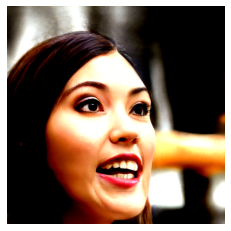

In [40]:
plt.imshow(img1.squeeze().permute(1,2,0).detach().numpy()) # drop batch (4dim -> 3dim)
plt.axis('off')
plt.savefig('fig1.png')
plt.show()
plt.close()

In [41]:
latent2 = torch.randn(1, 512, device=device)
img2 = g_all(latent2)
img2 = img2.clamp(-1,1)+1/2.0
img2 = img2.cpu()

img2.shape

torch.Size([1, 3, 1024, 1024])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


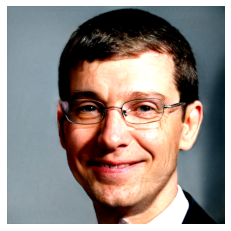

In [42]:
plt.imshow(img2.squeeze().permute(1,2,0).detach().numpy()) # drop batch (4dim -> 3dim)
plt.axis('off')
plt.savefig('fig2.png')
plt.show()
plt.close()

In [44]:
new_img = g_all(latent1*0.5 + latent2*0.5)
new_img = new_img.clamp(-1,1)+1/2.0
new_img = new_img.cpu()

new_img.shape

torch.Size([1, 3, 1024, 1024])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


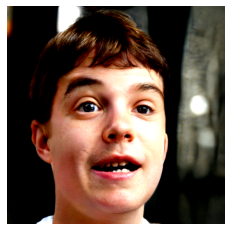

In [45]:
plt.imshow(new_img.squeeze().permute(1,2,0).detach().numpy()) 
plt.axis('off')
plt.savefig('fig3.png')
plt.show()
plt.close()

In [46]:
g_mapping = g_all[0] # We can extract mapping network like this.
g_mapping

G_mapping(
  (pixel_norm): PixelNormLayer()
  (dense0): MyLinear()
  (dense0_act): LeakyReLU(negative_slope=0.2)
  (dense1): MyLinear()
  (dense1_act): LeakyReLU(negative_slope=0.2)
  (dense2): MyLinear()
  (dense2_act): LeakyReLU(negative_slope=0.2)
  (dense3): MyLinear()
  (dense3_act): LeakyReLU(negative_slope=0.2)
  (dense4): MyLinear()
  (dense4_act): LeakyReLU(negative_slope=0.2)
  (dense5): MyLinear()
  (dense5_act): LeakyReLU(negative_slope=0.2)
  (dense6): MyLinear()
  (dense6_act): LeakyReLU(negative_slope=0.2)
  (dense7): MyLinear()
  (dense7_act): LeakyReLU(negative_slope=0.2)
)

In [47]:
g_synthesis = g_all[1]# Similarly, synthesis network can be extracted like this.

In [48]:
w_1 = g_mapping(latent1)
w_2 = g_mapping(latent2)

In [49]:
print(latent1.size(), w_1.size())
print(latent2.size(), w_2.size())

torch.Size([1, 512]) torch.Size([1, 18, 512])
torch.Size([1, 512]) torch.Size([1, 18, 512])


In [50]:
img3 = g_synthesis(w_1*0.5 + w_2*0.5)
img3 = img3.clamp(-1,1)+1/2.0
img3 = img3.cpu()

img3.shape

torch.Size([1, 3, 1024, 1024])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


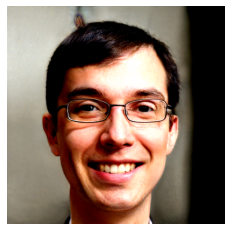

In [51]:
plt.imshow(img3.squeeze().permute(1,2,0).detach().numpy()) 
plt.axis('off')
plt.savefig('fig4.png')
plt.show()
plt.close()

In [52]:
itp_imgs = []

with torch.no_grad():
    for a in np.linspace(0, 1, 10):
        z = ((1-a) * latent1) + (a * latent2)
        result = g_all(z)
        result = result.clamp(-1,1)+1/2.0
        result = result.cpu()
        itp_imgs.append(result)

In [53]:
itp_imgs[0].size()

torch.Size([1, 3, 1024, 1024])

In [54]:
itp_imgs = torch.cat(itp_imgs)
itp_imgs.size()

torch.Size([10, 3, 1024, 1024])

In [55]:
grid_img = torchvision.utils.make_grid(itp_imgs, nrow=5)
grid_img.size()

torch.Size([3, 2054, 5132])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


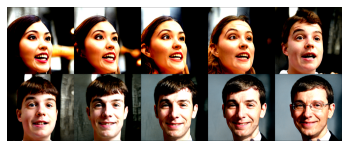

In [56]:
plt.imshow(grid_img.permute(1,2,0).detach().numpy())
plt.axis('off')
plt.savefig('final.png')
plt.show()
plt.close()

In [57]:
itp_imgs2 = []

with torch.no_grad():
    for a in np.linspace(0, 1, 10):
        w = ((1-a) * w_1) + (a * w_2)
        result2 = g_synthesis(w)
        result2 = result2.clamp(-1,1)+1/2.0
        result2 = result2.cpu()
        itp_imgs2.append(result2)

In [58]:
itp_imgs2[0].size()

torch.Size([1, 3, 1024, 1024])

In [59]:
itp_imgs2 = torch.cat(itp_imgs2)
itp_imgs2.size()

torch.Size([10, 3, 1024, 1024])

In [60]:
grid_img2 = torchvision.utils.make_grid(itp_imgs2, nrow=5)
grid_img2.size()

torch.Size([3, 2054, 5132])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


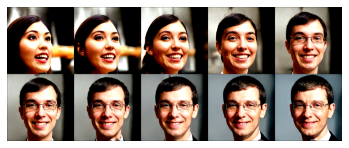

In [61]:
plt.imshow(grid_img2.permute(1,2,0).detach().numpy())
plt.axis('off')
plt.savefig('final2.png')
plt.show()
plt.close()